In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


"""
An `in-folder` reduction script CGM^2 Multi-Object Spectra

Note: You should really be running the prepare file to get this into the correct format...
"""

__author__ = "Matthew Wilde <mwilde@uw.edu>"
__version__ = "March 16, 2018"

try:
    from pyraf import iraf

except ImportError:
    raise ImportError("No pyraf module -- did you forget to do `source activate geminiconda`?")


import os
import copy
import shutil
from pyraf.iraf import gemini, gmos, gemtools
import numpy as np
from astropy.io import fits
from astropy.table import Table
import glob
import matplotlib.pyplot as plt
# from gmosutils import gmosutils
% matplotlib inline

path = os.path.abspath('.')

# Set colormap for plotting
cm = plt.get_cmap('Greys')

flatPrefix = 'MC' + 'gcalFlat' 
combName = 'MC' + 'gcalFlat' + 'Comb'
biasName = 'MCbiasFull.fits'


def observation_summary(filenames, additional_headers=None):
    """
    Create a table to serve as an observing summary.
    """
    
    # List the headers we want to extract
    headers = ["INSTRUME", "OBJECT", "OBSTYPE", "MASKNAME", "OBSCLASS", 
               "CENTWAVE", "GEMPRGID", "OBSID", "CCDBIN", "RAWPIREQ",
               "DATALAB", "UT", "DATE", "TIME-OBS", "GRATING", "EXPOSURE", "DETECTOR", "DATE-OBS"]
    
    if additional_headers is not None:
        headers += additional_headers

    rows = []
    for filename in filenames:
        with fits.open(filename) as image:
            rows.append(dict(zip(headers,
                [image[0].header.get(h, None) for h in headers])))

        # Add the filename.
        rows[-1]["FILENAME"] = filename

    headers.insert(0, "FILENAME")
    #headers.append("TIME")

    return Table(rows=rows, names=headers)

def show_img(img, z1, z2):
    plt.clf()
    ax = plt.gca()
    ax.imshow(img,vmin=z1,vmax=z2,cmap=cm, origin='lower')
    #
    plt.show()
    
def delete_inter_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*gs*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        
def delete_tmp_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*tmp*')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass

def delete_sci_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('J*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        
def get_bias():
    if not os.path.exists('MCbiasFull.fits'):
        print("No bias in this folder. copying from ../../../Bias/")
        from shutil import copyfile
        try:
            copyfile('../../../Bias/MCbiasFull.fits', './')
        except OSError:
            print('No bias? maybe need to make one')
            pass
    else:
        print("bias already exists, ready to roll!")
        
        


In [3]:
# get_bias()
# delete_tmp_files()

In [4]:
raw_files = glob.glob('N*fits')
summary = observation_summary(raw_files)
cent_waves = list(set(summary[(summary['OBSTYPE'] == 'OBJECT')]['CENTWAVE']))

# Mask 09. 

# Running with yoffset=-14


In [5]:
summary

FILENAME,INSTRUME,OBJECT,OBSTYPE,MASKNAME,OBSCLASS,CENTWAVE,GEMPRGID,OBSID,CCDBIN,RAWPIREQ,DATALAB,UT,DATE,TIME-OBS,GRATING,EXPOSURE,DETECTOR,DATE-OBS
str19,str6,str10,str6,str15,str10,float64,str13,str16,object,str7,str20,str10,str10,str11,str11,float64,str22,str10
N20150116S0251.fits,GMOS-N,CuAr,ARC,GN2014BLP003-09,dayCal,690.0,GN-2014B-LP-3,GN-2014B-LP-3-85,None,UNKNOWN,GN-2014B-LP-3-85-001,18:50:32.9,2015-01-16,18:51:11.0,R400+_G5305,20.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0095.fits,GMOS-N,GCALflat,FLAT,GN2014BLP003-09,partnerCal,690.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-002,13:59:20.4,2015-01-16,13:59:58.9,R400+_G5305,1.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0099.fits,GMOS-N,GCALflat,FLAT,GN2014BLP003-09,partnerCal,710.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-006,14:42:30.4,2015-01-16,14:43:08.9,R400+_G5305,1.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0098.fits,GMOS-N,J1059+1441,OBJECT,GN2014BLP003-09,science,710.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-005,14:21:45.4,2015-01-16,14:22:23.6,R400+_G5305,1200.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0094.fits,GMOS-N,J1059+1441,OBJECT,GN2014BLP003-09,science,690.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-001,13:38:35.4,2015-01-16,13:39:13.8,R400+_G5305,1200.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0097.fits,GMOS-N,J1059+1441,OBJECT,GN2014BLP003-09,science,700.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-004,14:00:56.9,2015-01-16,14:01:35.0,R400+_G5305,1200.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0096.fits,GMOS-N,GCALflat,FLAT,GN2014BLP003-09,partnerCal,700.0,GN-2014B-LP-3,GN-2014B-LP-3-83,None,YES,GN-2014B-LP-3-83-003,14:00:09.9,2015-01-16,14:00:48.3,R400+_G5305,1.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0253.fits,GMOS-N,CuAr,ARC,GN2014BLP003-09,dayCal,710.0,GN-2014B-LP-3,GN-2014B-LP-3-85,None,UNKNOWN,GN-2014B-LP-3-85-003,18:52:27.9,2015-01-16,18:53:05.10,R400+_G5305,20.0,GMOS + e2v DD CCD42-90,2015-01-16
N20150116S0252.fits,GMOS-N,CuAr,ARC,GN2014BLP003-09,dayCal,700.0,GN-2014B-LP-3,GN-2014B-LP-3-85,None,UNKNOWN,GN-2014B-LP-3-85-002,18:51:30.4,2015-01-16,18:52:08.6,R400+_G5305,20.0,GMOS + e2v DD CCD42-90,2015-01-16


N20150116S0094.fits


(400, 800)

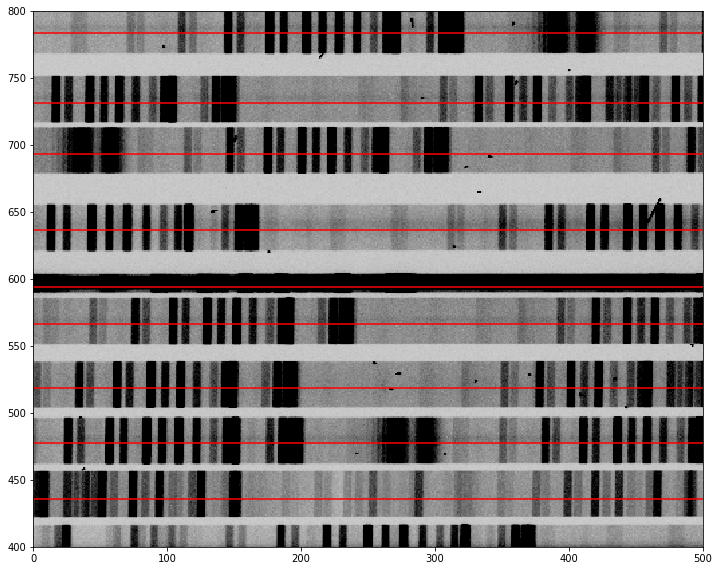

In [105]:
mask = Table.read('GN2014BLP003-09.fits', format='fits')
mask

idx = 2 
# dfile = 'MCgcalFlat' + str(cent_waves[0])+'.fits'
dfile = 'N20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape

plt.imshow(data,vmin=1000,vmax=1200,cmap=cm)
plt.hlines(mask['y_ccd']/2, 0, 4000, colors='red')
plt.xlim(0,500)
plt.ylim(400,800)


In [37]:
hdulist.info()

Filename: N20150116S0094.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   ()      
  1               -1 ImageHDU        38   (544, 2304)   int16 (rescales to uint16)   
  2               -1 ImageHDU        38   (544, 2304)   uint16   
  3               -1 ImageHDU        38   (544, 2304)   int16 (rescales to uint16)   
  4               -1 ImageHDU        38   (544, 2304)   int16 (rescales to uint16)   
  5               -1 ImageHDU        38   (544, 2304)   int16 (rescales to uint16)   
  6               -1 ImageHDU        38   (544, 2304)   int16 (rescales to uint16)   


In [96]:
idx = 2
# dfile = 'MCgcalFlat' + str(cent_waves[0])+'.fits'
dfile = 'gsN20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
mdf = Table(hdulist['MDF'].data)
mdf[:5]
# hdulist.info()


gsN20150116S0094.fits


ID,RA,DEC,x_ccd,y_ccd,specpos_x,specpos_y,slitpos_x,slitpos_y,slitsize_x,slitsize_y,slittilt,MAG,priority,wave_ccd,slitpos_mx,slitpos_my,slitid,slitsize_mx,slitsize_my,slittilt_m,slitsize_mr,slitsize_mw,slittype,EXTVER,REFPIX1,SECX1,SECX2,SECY1,SECY2,SPECCEN,SELECT
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,float32,float32,float32,int32,float32,float32,float32,float32,float32,str9,int32,int32,int32,int32,int32,int32,float32,int32
63,10.996139,14.65158,3281.0442,145.82169,-409.6355,0.0,0.0,0.0,1.0,5.0,0.0,22.936066,2,3258.7341,7.647604,-96.83718,1,0.62056154,3.1028075,90.0,0.0,0.0,rectangle,1,1613,1,3108,70,103,0.0,1
82,10.994328,14.65326,1983.6847,228.79662,321.12537,0.0,0.0,0.0,1.0,5.0,0.0,23.218695,2,2125.537,-51.02446,-92.9794,2,0.62056154,3.1028075,90.0,0.0,0.0,rectangle,2,1052,1,3108,113,146,0.0,1
118,10.994723,14.65567,2267.3162,347.8074,161.3645,0.0,0.0,0.0,1.0,5.0,0.0,21.11602,2,2373.2788,-38.21383,-87.64365,3,0.62056154,3.1028075,90.0,0.0,0.0,rectangle,3,1177,1,3108,172,205,0.0,1
160,10.995303,14.65722,2682.9849,424.65918,-72.76831,0.0,0.0,0.0,1.0,5.0,0.0,23.062918,2,2736.3506,-19.41663,-84.21887,4,0.62056154,3.1028075,90.0,0.0,0.0,rectangle,4,1357,1,3108,210,243,0.0,1
175,10.998474,14.65882,4955.3457,503.0845,-1850.6162,0.0,0.0,0.0,1.0,5.0,0.0,21.11772,2,4721.1763,83.37048,-80.4566,5,0.62056154,3.1028075,90.0,0.0,0.0,rectangle,5,2342,1,3108,251,284,0.0,1


# Make sure the y_offset is correct.
it looks like it is

N20150116S0094.fits


(-150, 400)

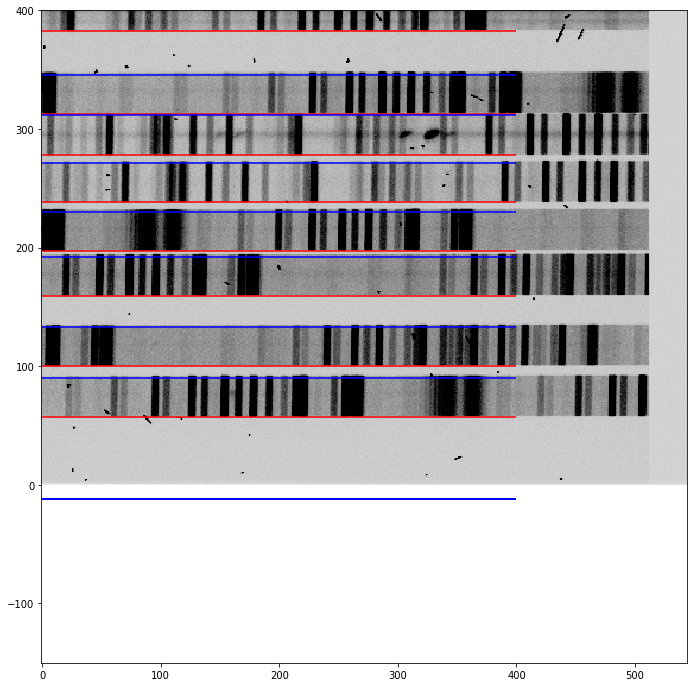

In [97]:
idx = 2
# dfile = 'MCgcalFlat' + str(cent_waves[0])+'.fits'
dfile = 'gsN20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
mdf = Table(hdulist['MDF'].data)
mdf[:5]
# hdulist.info()

dfile = 'N20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape

plt.imshow(data,vmin=1000,vmax=1200,cmap=cm)
plt.hlines(mdf['SECY1'] - 12.5, 0, 400, colors='red')
plt.hlines(mdf['SECY2'] - 12.5, 0, 400, colors='blue')
# plt.xlim(0,500)
plt.ylim(-150,400)


N20150116S0094.fits


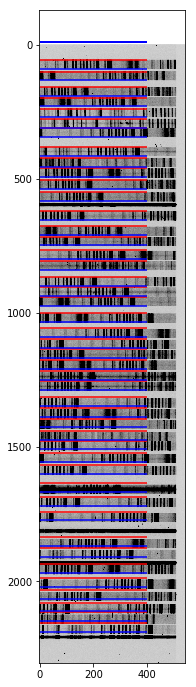

In [98]:
dfile = 'N20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape

plt.imshow(data,vmin=1000,vmax=1200,cmap=cm)
plt.hlines(mdf['SECY1'] - 13, 0, 400, colors='red')
plt.hlines(mdf['SECY2'] - 13, 0, 400, colors='blue')
# plt.xlim(0,500)
# plt.ylim(-150,400)

# Seems like the y_offset is not linear accross the ccd??

N20150116S0094.fits


(400, 900)

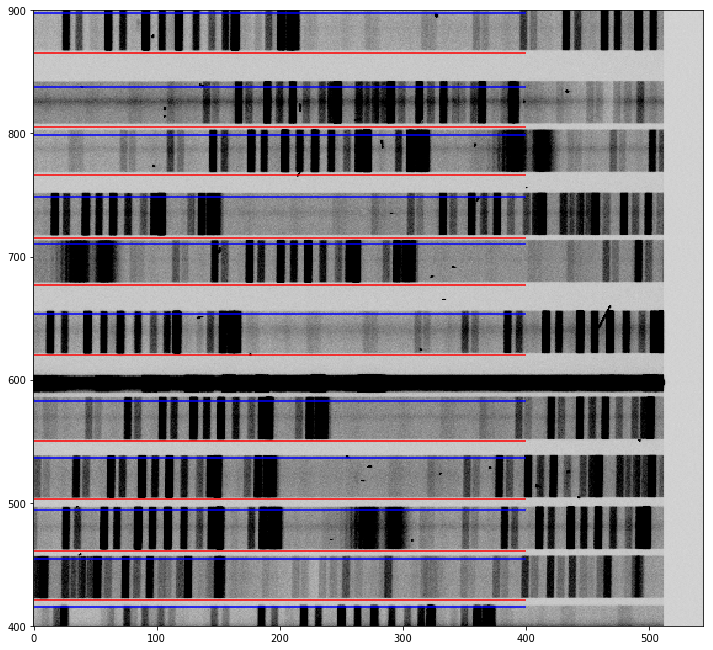

In [99]:
dfile = 'N20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape

plt.imshow(data,vmin=1000,vmax=1200,cmap=cm)
plt.hlines(mdf['SECY1'] - 13, 0, 400, colors='red')
plt.hlines(mdf['SECY2'] - 13, 0, 400, colors='blue')
# plt.xlim(0,500)
plt.ylim(400, 900)

N20150116S0094.fits


(1800, 2200)

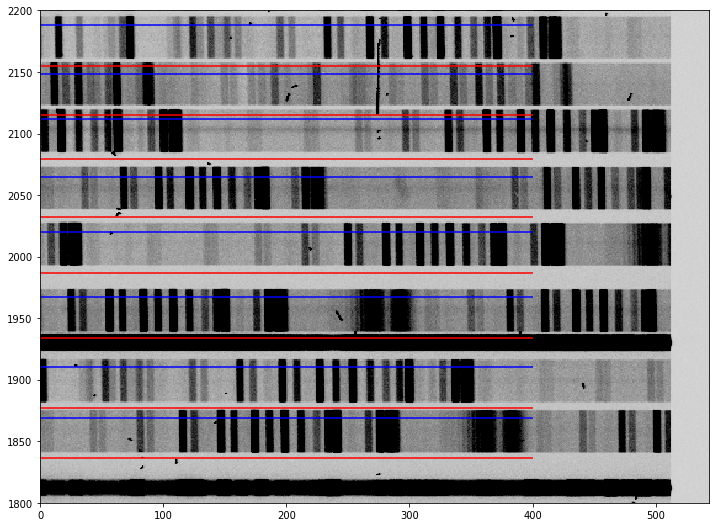

In [100]:
dfile = 'N20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape

plt.imshow(data,vmin=1000,vmax=1200,cmap=cm)
plt.hlines(mdf['SECY1'] - 13, 0, 400, colors='red')
plt.hlines(mdf['SECY2'] - 13, 0, 400, colors='blue')
# plt.xlim(0,500)
plt.ylim(1800, 2200)

# looking at the gs reduced slits....wtf is going wrong here?

gsN20150116S0094.fits


(1500, 1800)

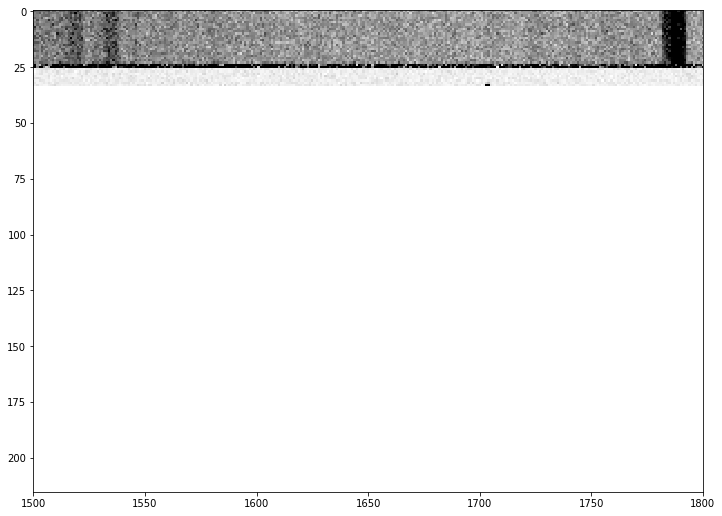

In [101]:
dfile = 'gsN20150116S0094.fits'
print(dfile)
plt.figure(figsize=(12,12))
hdulist = fits.open(dfile)
data = hdulist['SCI',idx].data
header = hdulist['SCI',idx].header
# data.shape

plt.imshow(data,vmin=0.,vmax=100.10,cmap=cm)
plt.hlines(mdf[idx]['SECY1'], 0, 400, colors='red')
plt.hlines(mdf[idx]['SECY2'], 0, 400, colors='blue')
plt.xlim(1500, 1800)
# plt.ylim(1800, 2200)

In [ ]:
delete_inter_files()

In [ ]:
! rm MCgcalFlat*

In [ ]:
print ("### Begin Processing GMOS/MOS Spectra ###")
print (' ')
print('IN FOLDER: ',path)
print (' ')
print ("=== Creating FLAT MasterCals ===")
if not os.path.exists(flatPrefix+str(cent_waves[1])+'.fits'):
    print (" -- Creating GCAL Spectral Flat-Field MasterCals --")
    print ("  -Full Flat (GCAL) normalization, non-interactive-")

    # Set the task parameters.
    gmos.gireduce.unlearn()
    gmos.gsflat.unlearn()
    flatFlags = {'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_dark':'no',
                'fl_fixpix':'no','fl_oversize':'yes','fl_vardq':'yes','fl_fulldq':'yes',
                'fl_inter':'no','fl_detec':'yes',
                'function':'spline3','order':'8',
                'logfile':'gsflatLog.txt','verbose':'no'
    }


    # TODO: make a case for LP data
    flatFlags.update({'fl_keep':'no','fl_usegrad':'no','fl_detec':'no',
                     'fl_seprows':'no','order':53, 'yoffset':-10})

    # flat type
    ft = 'gcalFlat'
    # loop over central wavelengths
    flatName=''
    combName=''
    for cw in cent_waves:
        flatName = 'MC' + ft + str(cw)
        combName = 'MC' + ft + 'Comb' + str(cw)
        flats = summary[(summary['OBSTYPE'] == 'FLAT') & (summary['CENTWAVE'] == cw)]['FILENAME']
        flatFull = [os.path.basename(f) for f in flats]
        gmos.gsflat (','.join(str(x) for x in flatFull), flatName, 
                     bias='MCbiasFull.fits', **flatFlags)
else:
    print('SKIPPING FLAT REDUX: '+flatPrefix+' already exists')

MCgcalFlat700.0.fits


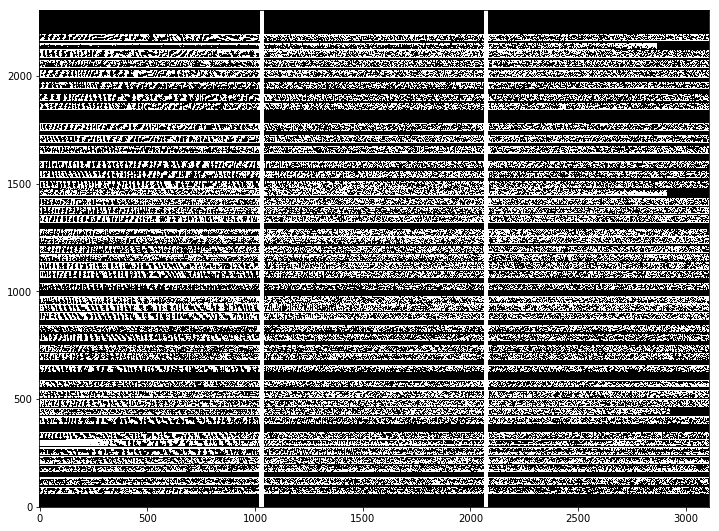

In [104]:
idx = 2 
dfile = 'MCgcalFlat' + str(cent_waves[1])+'.fits'
print(dfile)
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data, 0.999, 1)

MCgcalFlat700.0.fits


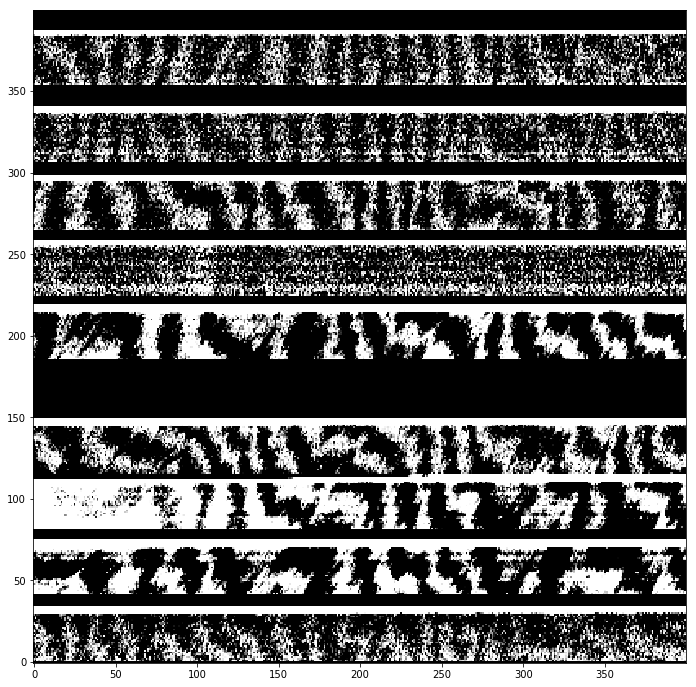

In [8]:
print(dfile)
plt.figure(figsize=(12,12))
show_img(data[200:600,200:600], 0.99, 1.0)

In [9]:
delete_sci_files()

In [10]:
! rm gN*fits

In [11]:
! rm -rf database/

In [12]:
print ("=== Processing Science Files ===")
print (" -- Performing Basic Processing --")

# Use primarily the default task parameters.
gmos.gsreduce.unlearn()
sciFlags = {
    'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
    'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
    'fl_gsappwave':'yes','fl_oversize':'yes',
    'fl_vardq':'yes','fl_fulldq':'yes',
    'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
}
arcFlags = copy.deepcopy(sciFlags)
arcFlags.update({'fl_flat':'no','fl_vardq':'no','fl_fulldq':'no'})


gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':6,'nsum':50,
    'function':'chebyshev','order':7,
    'fl_inter':'no','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':2})


gmos.gstransform.unlearn()
transFlags = {
    'fl_vardq':'yes','interptype':'linear','fl_flux':'yes',
    'logfile':'gstransformLog.txt','verbose':'no'
}

print ('  - MOS Science and Arc exposures -')
prefix = 'gs' # 
ft = 'gcalFlat' # flat type
for i,cw in enumerate(cent_waves):
    flatName = 'MC' + ft + str(cw)
    gradName = 'MC' + ft + 'Comb' + str(cw)
    
    ################### ARCS: Reduce and find wavelengths ###############################
    # Arcs
    # arcFull = fs.fileListQuery(dbFile, fs.createQuery('arc', qdf), qdf)
    arcs = summary[(summary['OBSTYPE'] == 'ARC') & (summary['CENTWAVE'] == cw)]['FILENAME']
    arcFull = [os.path.basename(f) for f in arcs]
    reduced_arcs = [prefix + str(x) for x in arcFull]
    if not os.path.exists(reduced_arcs[0]):
        gmos.gsreduce (','.join(str(x) for x in arcFull), bias=biasName,   **arcFlags)
        gmos.gswavelength(','.join(prefix+str(x) for x in arcFull), **waveFlags)
    
    ################### SCI: Reduce and find wavelengths ###############################
    # Science Images
    # sciFull = fs.fileListQuery(dbFile, fs.createQuery('sciSpec', qdf), qdf)
    sci = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['FILENAME']
    sciFull = [os.path.basename(f) for f in sci]
    
    
    reduced_imgs = [prefix + str(x) for x in sciFull]
    
    
    # get the quasar name convention right: quasar+mask+centwave
    quasar_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
    maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
    outFile = quasar_name+'_m'+maskname+'_'+str(cw)[:-2]
    outFile = outFile.replace('+','_')
    
    gmos.gsreduce.unlearn()
    
    
    # Rollup: 2 central waves and 2 exposures at each. 
    # This means we can combine the exposure at the same central wavelength to perform
    # cosmic ray reduction
    if len(cent_waves) < 3:
        
        # reduce the SCIENCE images
        if not os.path.exists(reduced_imgs[0]):
            gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName,   **sciFlags)
        
        
        # Set CR task parameters.
        # NOTE: Turned on crreject. Does a good job of getting rid of cosmic rays
        gemtools.gemcombine.unlearn()
        sciCombFlags = {
            'combine':'average','reject':'crreject',
            'fl_vardq':'yes','fl_dqprop':'yes',
            'logfile':'gemcombineLog.txt','verbose':'no'
        }
        # Rollup data with 2 science exposures and 2 centwaves
        i = i + 1
        combined_outFile = "cr_sci"+str(i)+"w_auto_slit.fits"
        
        # combine the 2 exposures at the same central wavelength
        gemtools.gemcombine (','.join(prefix+str(x) for x in sciFull), combined_outFile,
                               **sciCombFlags)
        # transform the sci images
        gmos.gstransform (combined_outFile, wavtraname='gs'+arcFull[0], outimages=outFile,
                          **transFlags)
    else:
        # This is the Long Program data with 3 central wavelength with 1 exposure at each. 
        # Cosmic ray reduction needs to be performed with LA cosmic gemcrspec. 
        # can be done with fl_crspec=yes in gs reduce...
    
        sciFlags = {
            'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
            'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
            'fl_gsappwave':'yes','fl_oversize':'yes',
            'fl_vardq':'yes','fl_fulldq':'yes',
            'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
        }
        
        # reduce the SCIENCE images
        if not os.path.exists(reduced_imgs[0]):
            gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName, **sciFlags)
            # LP with 3 central wavelengths and 1 science exposure
        else:
            print("skipping gsreduce: file already exists "+reduced_imgs[0]+".fits")
        # get the quasar name convention right: quasar+mask+centwave
        quasar_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
        maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
        outFile = quasar_name+'_m'+maskname+'_'+str(cw)[:-2]
        outFile = outFile.replace('+','_')
        
        if not os.path.exists(outFile+".fits"):
            # transform the sci images
            gmos.gstransform (reduced_imgs[0], wavtraname='gs'+arcFull[0], outimages=outFile,
                          **transFlags)
        else:
            print("skipping gstransform: file already exists "+outFile+".fits")

        

=== Processing Science Files ===
 -- Performing Basic Processing --
  - MOS Science and Arc exposures -
GPREPARE: Using MDF defined in the header GN2014BLP003-09
GPREPARE: Using MDF defined in the header GN2014BLP003-09
WARNING - GIREDUCE: Bad Pixel Mask filename is an empty string
                    Only saturated pixels will be flagged
GPREPARE: Using MDF defined in the header GN2014BLP003-09
GPREPARE: Using MDF defined in the header GN2014BLP003-09
WARNING - GIREDUCE: Bad Pixel Mask filename is an empty string
                    Only saturated pixels will be flagged
GPREPARE: Using MDF defined in the header GN2014BLP003-09


Killing IRAF task `autoidentify'


IrafError: Error running IRAF task autoidentify
IRAF task terminated abnormally
ERROR (1, "Coordinate solution is not monotonic")


In [ ]:
# Use primarily the default task parameters.
gmos.gsreduce.unlearn()
sciFlags = {
    'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
    'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
    'fl_gsappwave':'yes','fl_oversize':'yes',
    'fl_vardq':'yes','fl_fulldq':'yes',
    'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
}
arcFlags = copy.deepcopy(sciFlags)
arcFlags.update({'fl_flat':'no','fl_vardq':'no','fl_fulldq':'no'})


gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':6,'nsum':50,
    'function':'chebyshev','order':7,
    'fl_inter':'yes','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':20})


gmos.gstransform.unlearn()
gmos.gsreduce ('N20150116S0253.fits', bias=biasName,   **arcFlags)
gmos.gswavelength('gsN20150116S0253.fits', **waveFlags)

In [ ]:
iraf.autoidentify('gsN20150116S0253.fits',step=20, coordlist='gmos$data/CuAr_GMOS.dat', )

In [ ]:
hdulist = fits.open('N20150116S0253.fits')
# hdulist.info()
hdulist[1].data

In [ ]:
dfile = "GN2014BLP003-09.fits"
hdulist = fits.open(dfile)
hdulist.info()
mdf = hdulist[1].data

In [ ]:
tab = Table(mdf)
tab

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(tab['slitpos_mx'], tab['slitpos_my'])

In [ ]:
gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':10,
    'function':'chebyshev','order':7,
    'fl_inter':'yes','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':10})

In [ ]:
gmos.gswavelength('gsN20150116S0253.fits', **waveFlags)

In [ ]:
glob.glob('J*fits')

In [ ]:
test_files = glob.glob('J*fits')
idx = 5
dfile = test_files[0]
hdulist = fits.open(dfile)
data = hdulist['sci',idx].data
header = hdulist['sci',idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data[:,1500:1800], 0.8, 800)


In [ ]:
delete_tmp_files()

In [ ]:
! ls

In [ ]:
local_pid = list(set(summary['GEMPRGID']))[0]
local_pid, project_IDs[0]